In [1]:
from gwpy.timeseries import TimeSeries
import sys
sys.path.append('..')
from src.utils import simulate_mains_hum, sideband_nonlinear_coupling, visualize_data



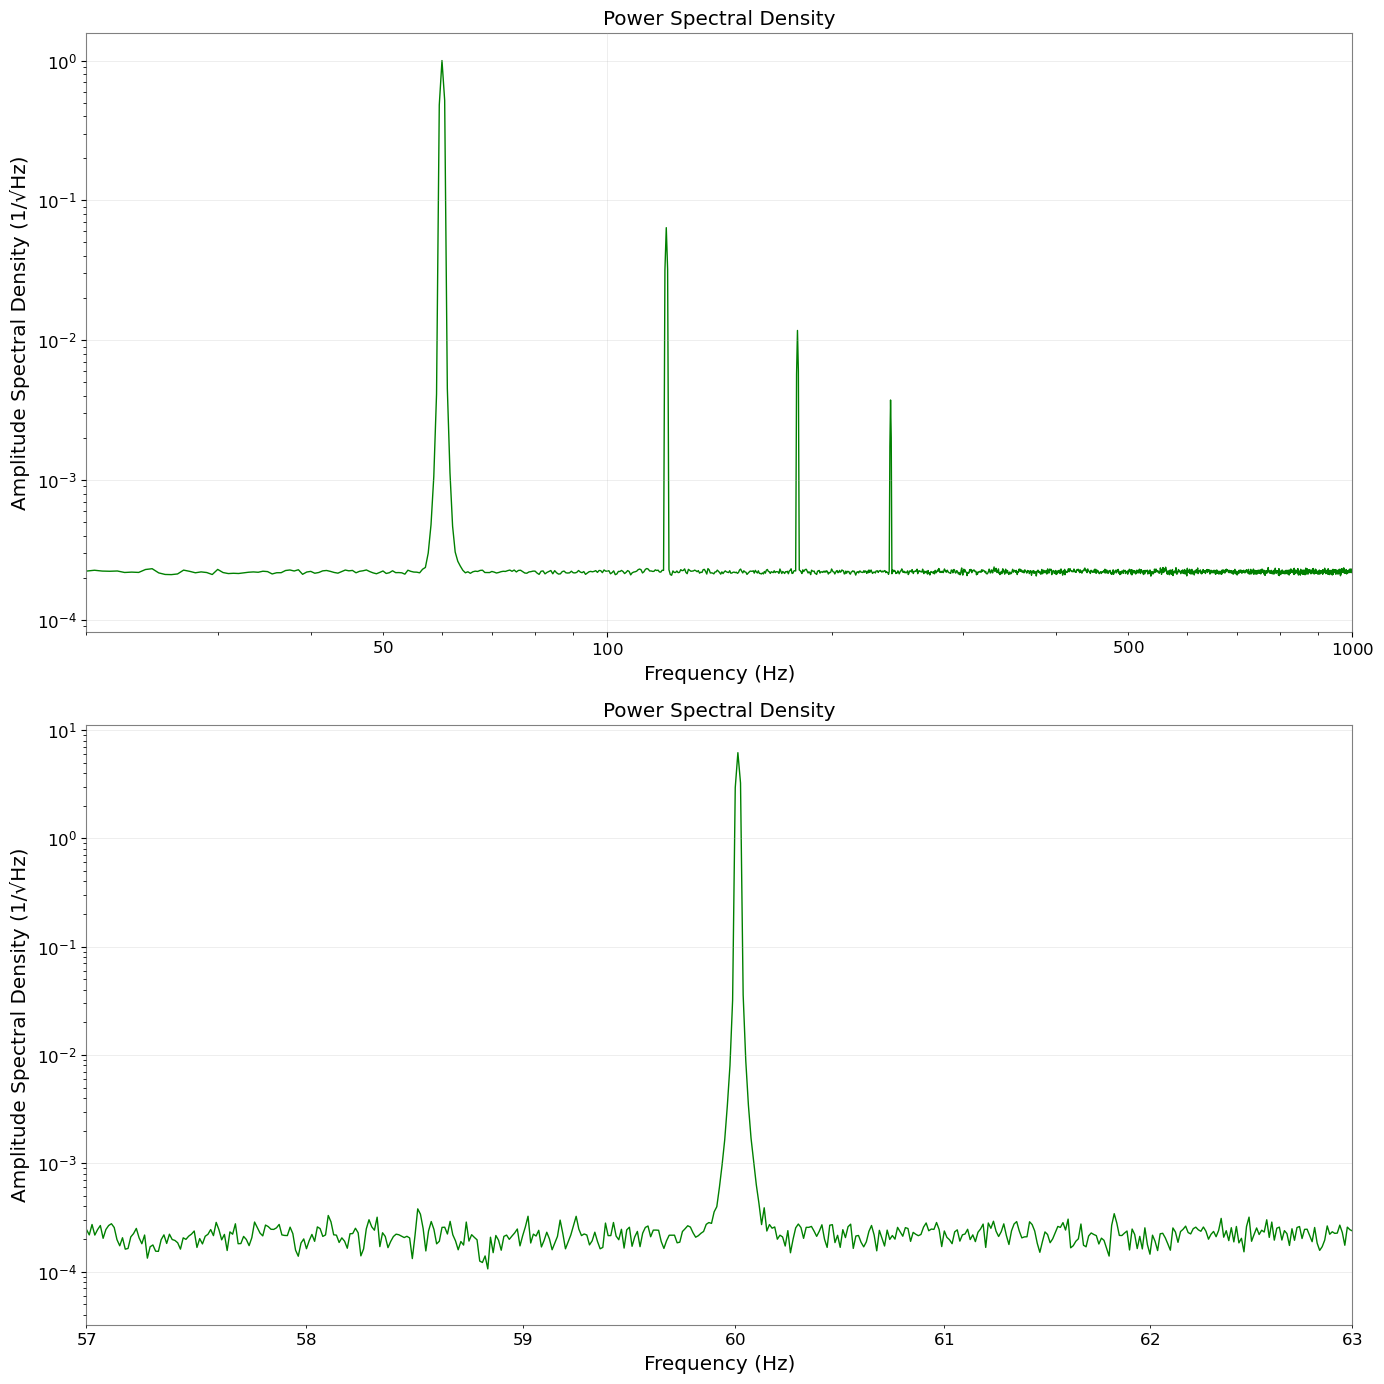

In [8]:
import numpy as np
import matplotlib.pyplot as plt
data = simulate_mains_hum()
dataTS = TimeSeries(data, unit = 's', t0 = 0, dt = 1 / 4096)
def visualize_data(data):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 14))

    # 3. Power Spectral Density (PSD)
    psd = data.psd(fftlength=2, overlap=1)
    axes[0].loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[0].set_title('Power Spectral Density')
    axes[0].set_xlim(20, 1000)
    #axes.set_ylim(ymin, ymax)
    axes[0].grid(True, alpha=0.3)

    psd = data.psd(fftlength=80, overlap=20)
    axes[1].loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[1].set_title('Power Spectral Density')
    axes[1].set_xlim(57, 63)
    #axes.set_ylim(ymin, ymax)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


visualize_data(dataTS)

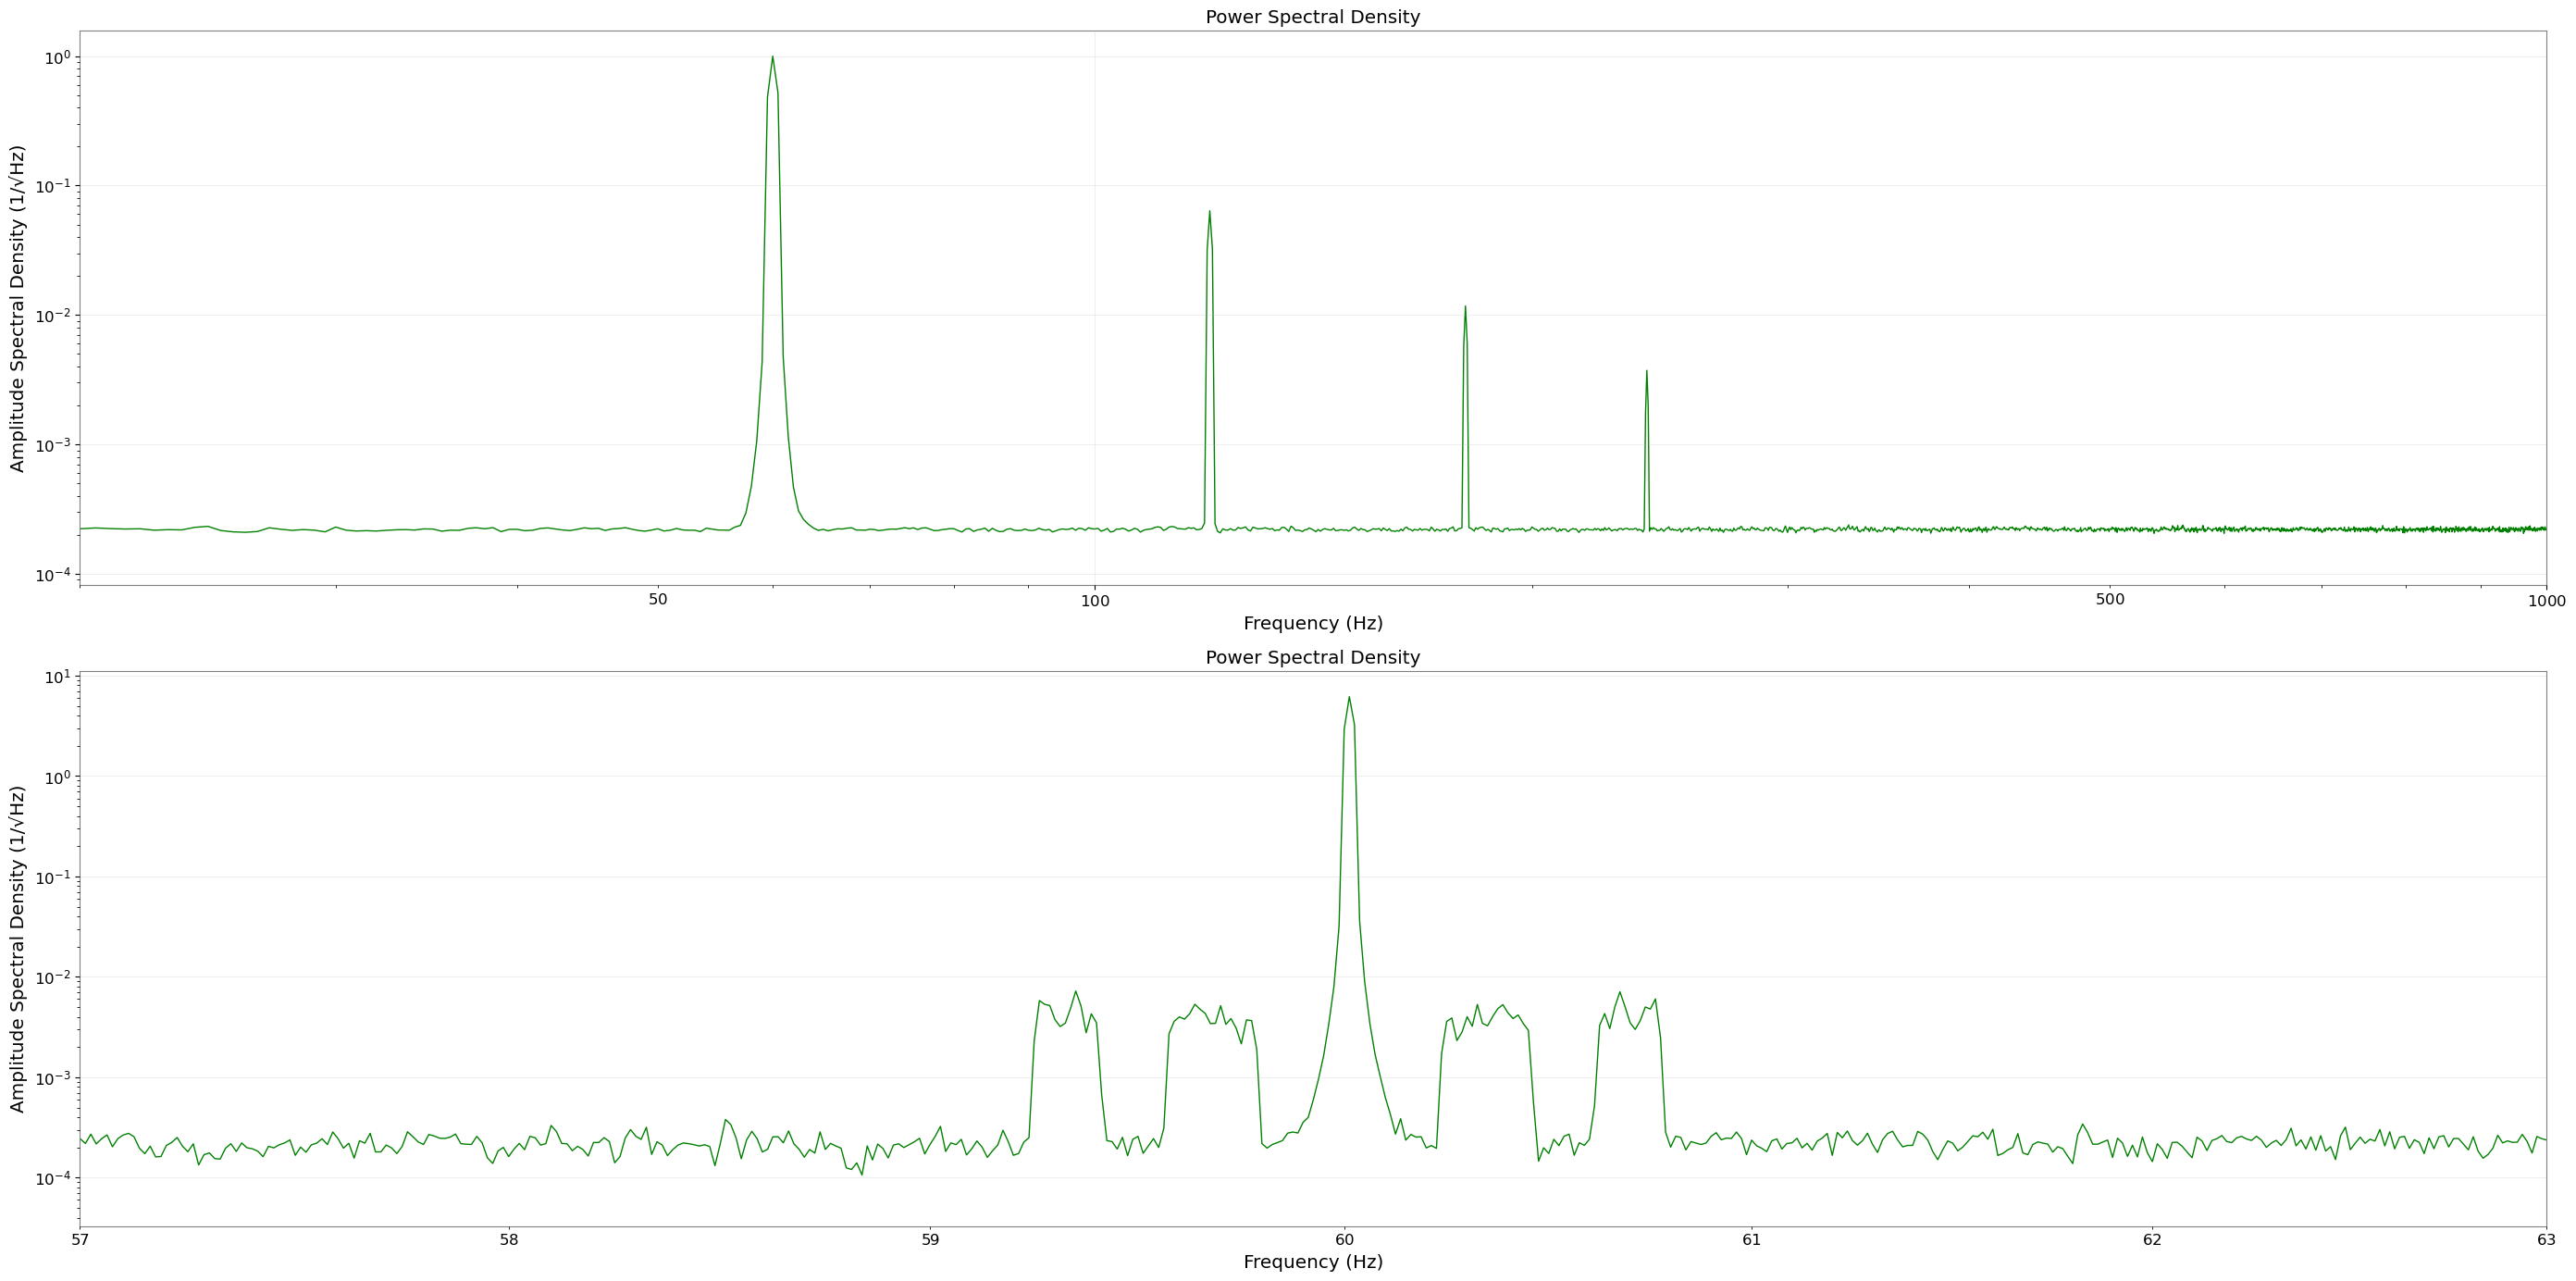

In [4]:
data = simulate_mains_hum()
data2 = sideband_nonlinear_coupling(data)
dataTS2 = TimeSeries(data2, unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(dataTS2)

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('..')

from src.model import DeepCleanAutoencoder
from src.dataset import GWDataset
from src.utils import postprocess

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

TEST_DATA_PATH = '../data/train_data_raw.npz' 

data = np.load(TEST_DATA_PATH)
strain_raw = data['strain']
witnesses_raw = data['witnesses']


Running on device: cuda


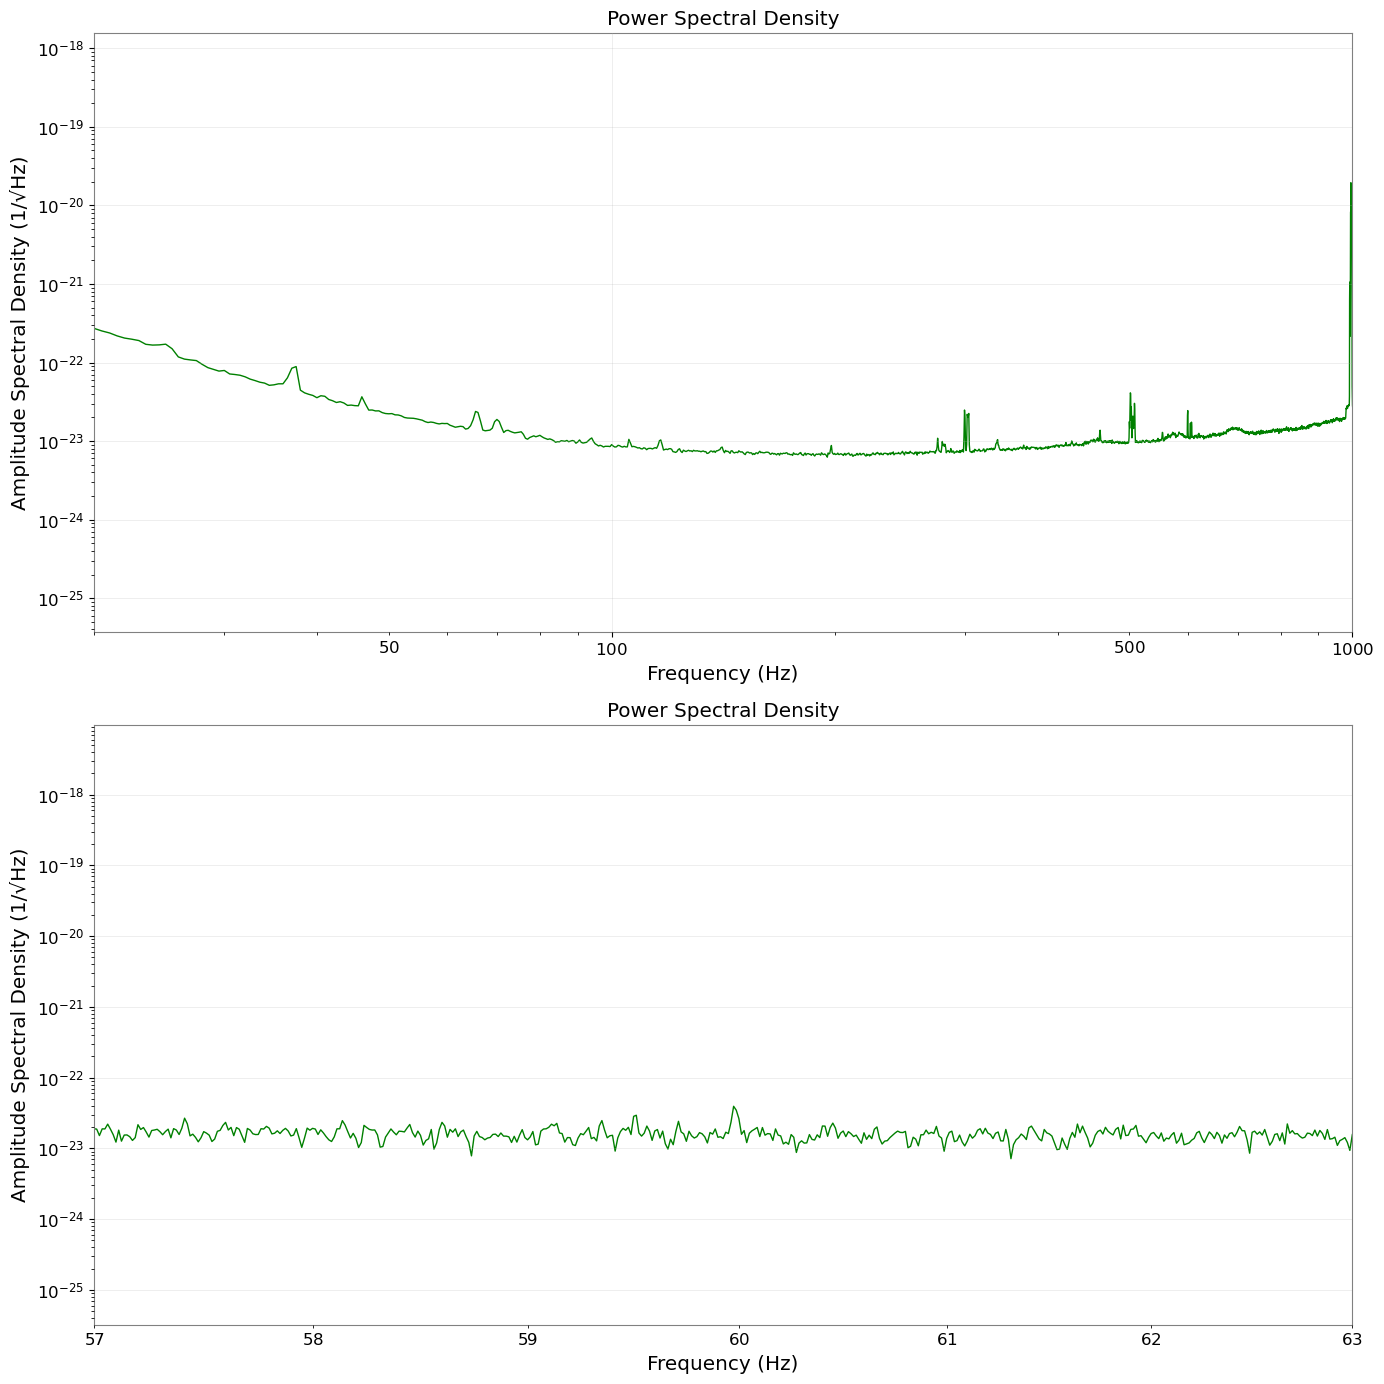

In [11]:
dataTSReal = TimeSeries(data['strain'], unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(dataTSReal)

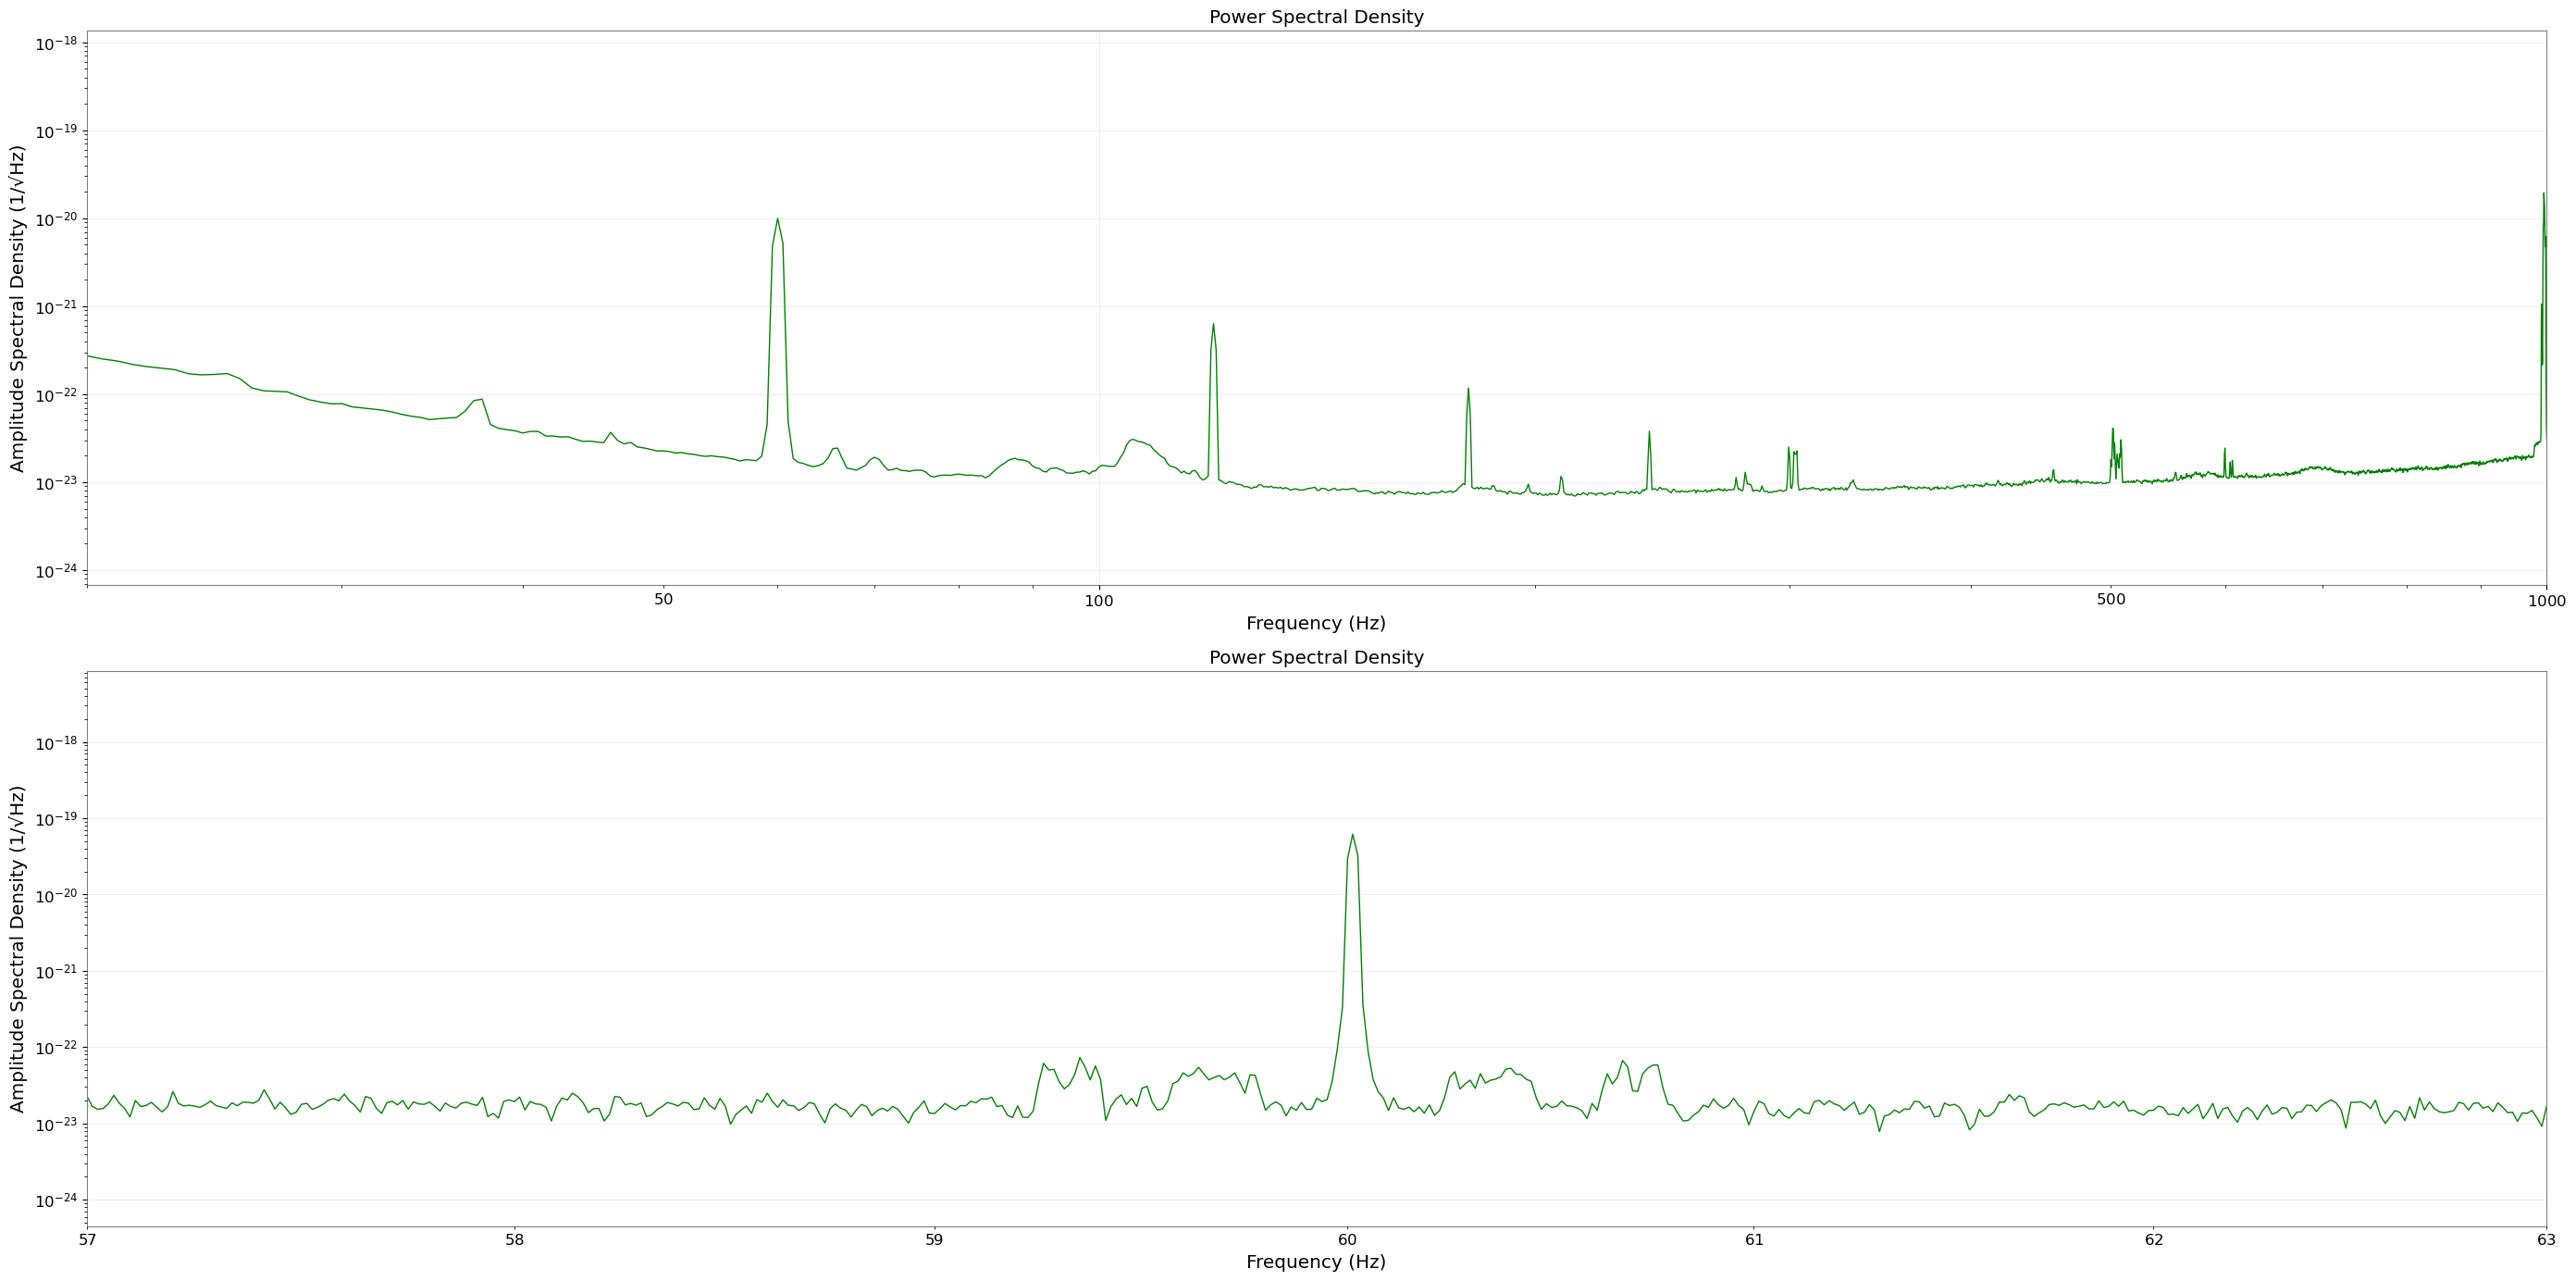

In [7]:
mainsHumWitness = simulate_mains_hum()
modulatedNoise = sideband_nonlinear_coupling(mainsHumWitness)

simulatedNoisedData = data['strain'] + modulatedNoise * 1e-20

for i, channel in enumerate(data['witnesses']):
    channel = np.array(channel)  
    # normalize to [-1, 1]
    normalizedWitnessChannel = 2 * (channel - channel.min()) / (channel.max() - channel.min()) - 1
    simulatedNoisedData += normalizedWitnessChannel * 3e-22
    
    
simulatedData = TimeSeries(simulatedNoisedData, unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(simulatedData)